In [1]:
import sys
sys.path.append('../')
sys.path.append('./git_clone_liibraries/')
import scipy.io as sio
import mat73
import pandas as pd
import torch
import numpy as np
import torch.optim as optim
import torch.nn
import sklearn.metrics
import matplotlib.pyplot as plt
from  utils.my_classes import dataset 
from torch.utils.data import DataLoader
import utils.DNN_functions as DNN_functions
import scipy
import random
import pickle
import os
from utils.my_classes import dataset
import utils.eval_metrics as eval_metrics
import copy
import ASV_utils.data_loading as dl
import utils.my_functions as my_functions
import pandas as pd
from utils.my_functions import compute_eer , compute_eer_2


C:\Users\avish\AppData\Local\Temp\ipykernel_22308\2546413608.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  unique_colors = plt.cm.get_cmap("tab10", 2)  # Use 2 colors for bonafide & spoof


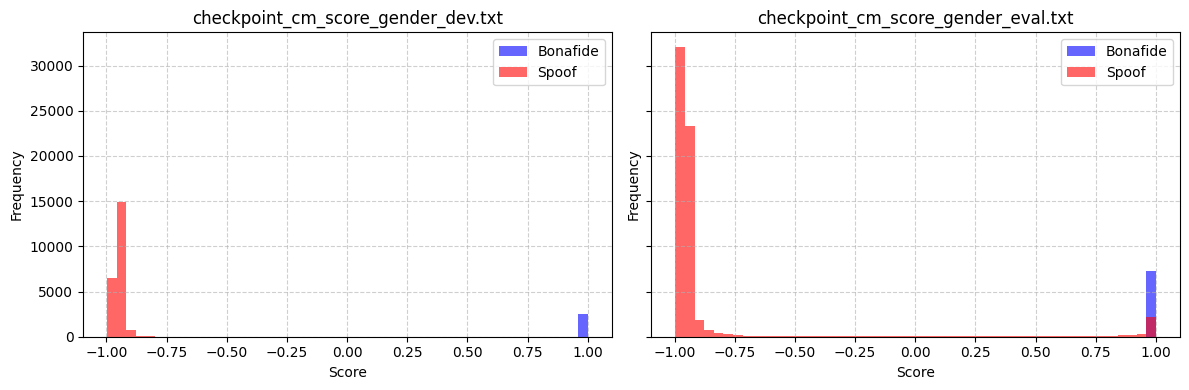

C:\Users\avish\AppData\Local\Temp\ipykernel_22308\2546413608.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  unique_colors = plt.cm.get_cmap("tab10", 2)  # Use 2 colors for bonafide & spoof


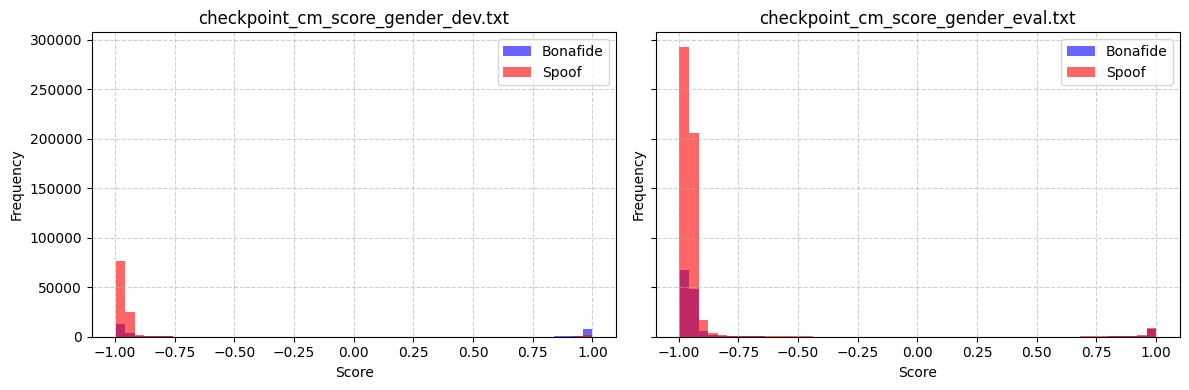

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_histogram_comparison(file_paths, gender="all"):
    num_files = len(file_paths)
    cols = 2  # Number of columns in the subplot grid
    rows = (num_files + cols - 1) // cols  # Calculate required rows
    unique_colors = plt.cm.get_cmap("tab10", 2)  # Use 2 colors for bonafide & spoof

    fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 4), sharex=True, sharey=True)
    axes = axes.flatten()  # Flatten the axes array for easy indexing

    for idx, file_path in enumerate(file_paths):
        df = pd.read_csv(file_path, delim_whitespace=True, header=None,
                         names=["file_id", "speakers", "attack_type", "label", "score", "gender"])

        mapping_labels = {"bonafide": 1, "spoof": -1}
        df["label"] = df["label"].map(mapping_labels)

        if gender == "male":
            df = df.loc[df["gender"] == "male"]
        elif gender == "female":
            df = df.loc[df["gender"] == "female"]

        # Separate bonafide and spoof scores
        bonafide_scores = df[df["label"] == 1]["score"]
        spoof_scores = df[df["label"] == -1]["score"]

        # Plot histograms
        axes[idx].hist(bonafide_scores, bins=50, alpha=0.6, color="blue", label="Bonafide")
        axes[idx].hist(spoof_scores, bins=50, alpha=0.6, color="red", label="Spoof")
        
        # Formatting
        axes[idx].set_title(file_path.split("/")[-1], fontsize=12)
        axes[idx].set_xlabel("Score", fontsize=10)
        axes[idx].set_ylabel("Frequency", fontsize=10)
        axes[idx].legend()
        axes[idx].grid(True, linestyle="--", alpha=0.6)

    # Hide any unused subplots
    for ax in axes[len(file_paths):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

file_paths = [
    "./bonafide_tests/ASVspoof2019_bonafide/checkpoint_cm_score_gender_dev.txt",
    "./bonafide_tests/ASVspoof2019_bonafide/checkpoint_cm_score_gender_eval.txt"
]
plot_histogram_comparison(file_paths)

file_paths = [
    "./bonafide_tests/ASVspoof5_bonafide/checkpoint_cm_score_gender_dev.txt",
    "./bonafide_tests/ASVspoof5_bonafide/checkpoint_cm_score_gender_eval.txt"
]
plot_histogram_comparison(file_paths)

In [18]:
def compute_eer_from_text_file(file_path, threshold=None,gender = "all"):
    df = pd.read_csv(file_path, delim_whitespace=True, header=None, 
                 names=["file_id", "speakers", "attack_type", "label", "score", "gender"])

    mapping_labels = {"bonafide": 1, "spoof": -1}

    df.label = df.label.map(mapping_labels)
    
    if gender == "male":
        df = df.loc[df["gender"] == "male"]
    
    if gender ==  "female":
        df = df.loc[df["gender"] == "female"]
        

    pred, labels , eer , misclassifications , misclassification_rate = [], [], [], [], []
    if threshold is None:
        
        eer, threshold = compute_eer( y= df.label.values, y_score = df.score.values)
    else:
        pred = (df.score.values > threshold).astype(int)
        labels = df.label.values 
    
    #misscalssification rate
        misclassifications = (pred != labels).sum()  # Count mismatches
        misclassification_rate = misclassifications / len(df)  # Rate
    
    
    return eer, threshold , pred , labels , misclassifications , misclassification_rate


# Define the path to the text file
file_path = "./bonafide_tests/ASVspoof5_bonafide/checkpoint_cm_score_gender_dev.txt"

eer_dev, threshold_dev , _ , _ , _ , _ = compute_eer_from_text_file(file_path)
print(f"eer_dev: {eer_dev}, threshold_dev: {threshold_dev}")

eer_dev: 0.380513180570626, threshold_dev: -0.9602207737928634


In [19]:
file_path = "./bonafide_tests/ASVspoof2019_bonafide/checkpoint_cm_score_gender_dev_bonafide.txt"

_, _ , pred , labels , misclassifications , misclassification_rate = compute_eer_from_text_file(file_path,threshold_dev)
print(f"eer_dev: {eer_dev}, threshold_dev: {threshold_dev}")

print(f"misclassifications: {misclassifications}")
print(f"misclassification_rate: {100*misclassification_rate}%")

eer_dev: 0.380513180570626, threshold_dev: -0.9602207737928634
misclassifications: 1
misclassification_rate: 0.03924646781789639%


In [20]:
file_path = "./bonafide_tests/ASVspoof2019_bonafide/checkpoint_cm_score_gender_eval_bonafide.txt"

_, _ , pred , labels , misclassifications , misclassification_rate = compute_eer_from_text_file(file_path,threshold_dev)
print(f"eer_dev: {eer_dev}, threshold_dev: {threshold_dev}")

print(f"misclassifications: {misclassifications}")
print(f"misclassification_rate: {100*misclassification_rate}%")

eer_dev: 0.380513180570626, threshold_dev: -0.9602207737928634
misclassifications: 8
misclassification_rate: 0.10876954452753229%


In [21]:
file_path = "./bonafide_tests/ASVspoof5_bonafide/checkpoint_cm_score_gender_dev_bonafide.txt"

_, _ , pred , labels , misclassifications , misclassification_rate = compute_eer_from_text_file(file_path,threshold_dev)
print(f"eer_dev: {eer_dev}, threshold_dev: {threshold_dev}")

print(f"misclassifications: {misclassifications}")
print(f"misclassification_rate: {100*misclassification_rate}%")

eer_dev: 0.380513180570626, threshold_dev: -0.9602207737928634
misclassifications: 11922
misclassification_rate: 38.048126635603495%


In [22]:
file_path = "./bonafide_tests/ASVspoof5_bonafide/checkpoint_cm_score_gender_eval_bonafide.txt"

_, _ , pred , labels , misclassifications , misclassification_rate = compute_eer_from_text_file(file_path,threshold_dev)
print(f"eer_dev: {eer_dev}, threshold_dev: {threshold_dev}")

print(f"misclassifications: {misclassifications}")
print(f"misclassification_rate: {100*misclassification_rate}%")

eer_dev: 0.380513180570626, threshold_dev: -0.9602207737928634
misclassifications: 63515
misclassification_rate: 45.79704083987079%


### Plotting:

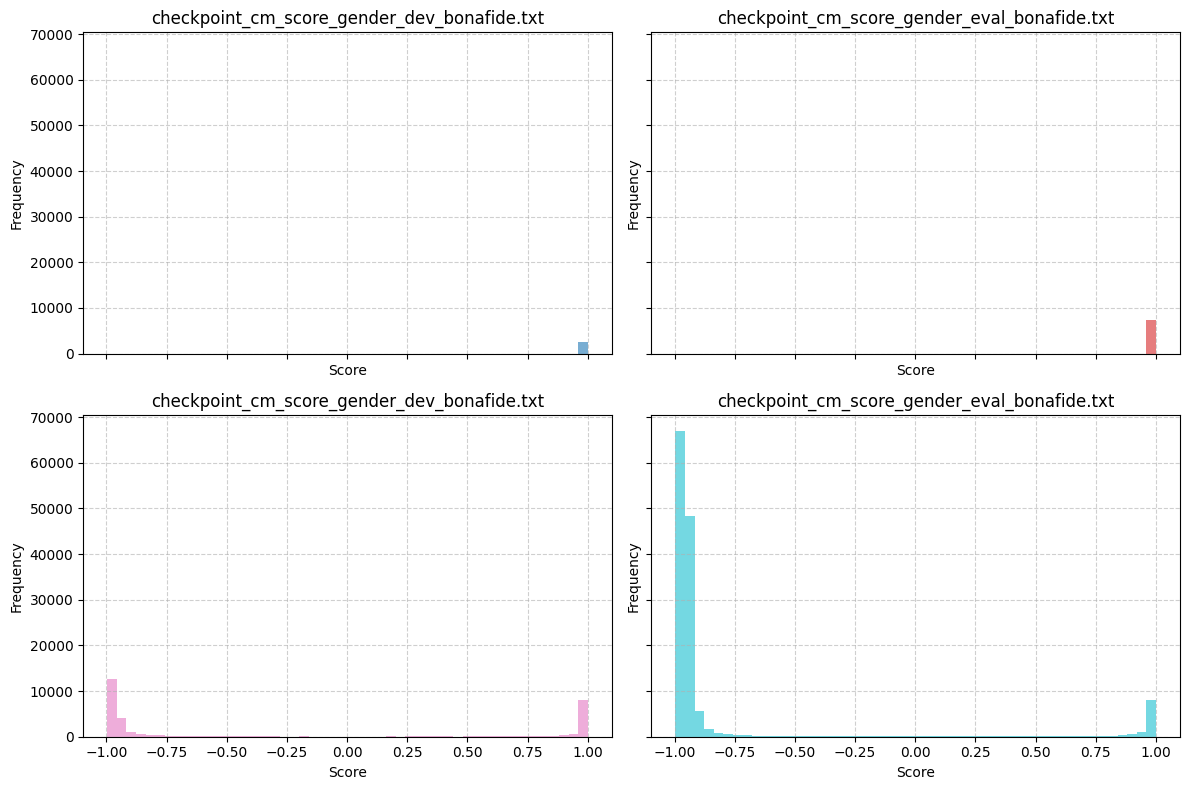

In [23]:
import pandas as pd
import matplotlib.pyplot as plt


import pandas as pd
import matplotlib.pyplot as plt

def plot_histogram_comparison(file_paths, gender="all"):
    num_files = len(file_paths)
    cols = 2  # Number of columns in the subplot grid
    rows = (num_files + cols - 1) // cols  # Calculate required rows
    unique_colors = plt.cm.get_cmap("tab10", num_files)

    fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 4), sharex=True, sharey=True)
    axes = axes.flatten()  # Flatten the axes array for easy indexing

    for idx, file_path in enumerate(file_paths):
        df = pd.read_csv(file_path, delim_whitespace=True, header=None,
                         names=["file_id", "speakers", "attack_type", "label", "score", "gender"])

        mapping_labels = {"bonafide": 1, "spoof": -1}
        df["label"] = df["label"].map(mapping_labels)

        if gender == "male":
            df = df.loc[df["gender"] == "male"]
        elif gender == "female":
            df = df.loc[df["gender"] == "female"]

        # Plot histogram in the appropriate subplot
        axes[idx].hist(df["score"], bins=50, alpha=0.6, color=unique_colors(idx))
        axes[idx].set_title(file_path.split("/")[-1], fontsize=12)
        axes[idx].set_xlabel("Score", fontsize=10)
        axes[idx].set_ylabel("Frequency", fontsize=10)
        axes[idx].grid(True, linestyle="--", alpha=0.6)

    # Hide any unused subplots
    for ax in axes[len(file_paths):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()



# Example usage
file_paths = [
    "./bonafide_tests/ASVspoof2019_bonafide/checkpoint_cm_score_gender_dev_bonafide.txt",
    "./bonafide_tests/ASVspoof2019_bonafide/checkpoint_cm_score_gender_eval_bonafide.txt",
    "./bonafide_tests/ASVspoof5_bonafide/checkpoint_cm_score_gender_dev_bonafide.txt",
    "./bonafide_tests/ASVspoof5_bonafide/checkpoint_cm_score_gender_eval_bonafide.txt"
]
plot_histogram_comparison(file_paths)




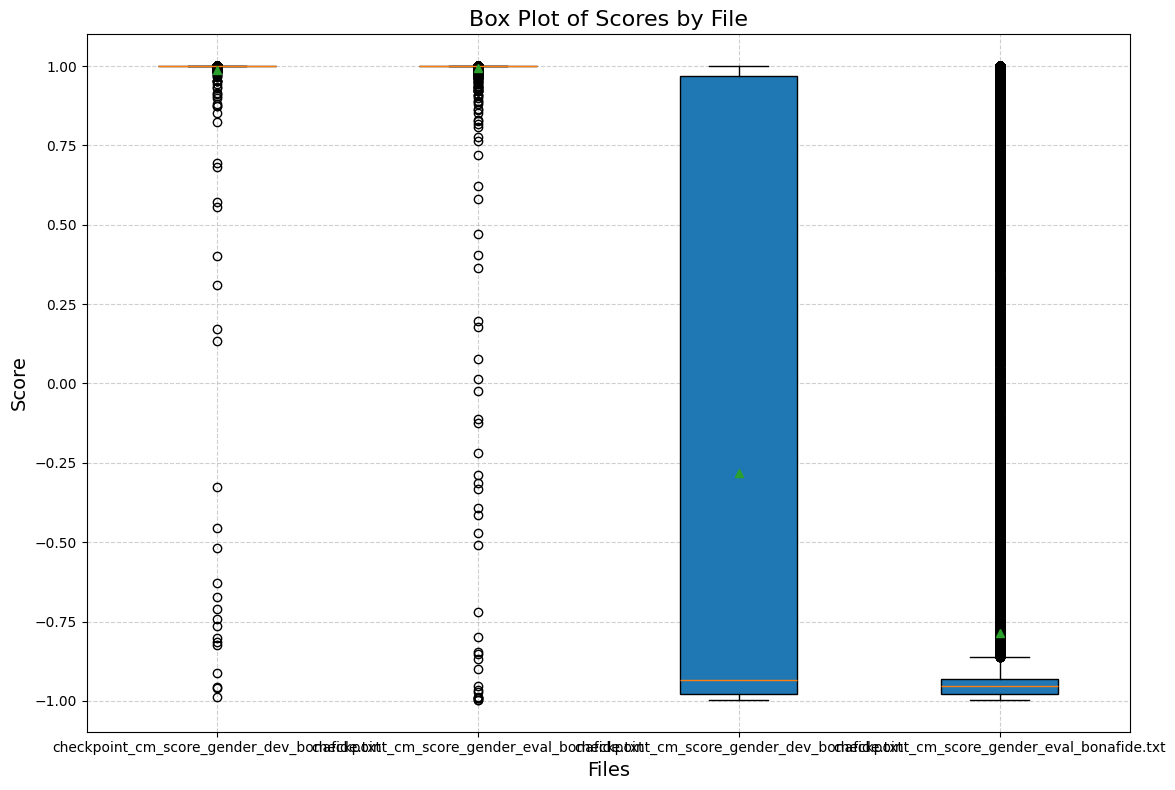

In [24]:
def plot_box_comparison(file_paths, gender="all"):
    data = []
    labels = []

    for file_path in file_paths:
        df = pd.read_csv(file_path, delim_whitespace=True, header=None,
                         names=["file_id", "speakers", "attack_type", "label", "score", "gender"])

        mapping_labels = {"bonafide": 1, "spoof": -1}
        df["label"] = df["label"].map(mapping_labels)

        if gender == "male":
            df = df.loc[df["gender"] == "male"]
        elif gender == "female":
            df = df.loc[df["gender"] == "female"]

        # Collect scores and labels for box plot
        data.append(df["score"])
        labels.append(file_path.split("/")[-1])

    plt.figure(figsize=(12, 8))
    plt.boxplot(data, labels=labels, vert=True, patch_artist=True, showmeans=True)
    plt.title("Box Plot of Scores by File", fontsize=16)
    plt.ylabel("Score", fontsize=14)
    plt.xlabel("Files", fontsize=14)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

# Example usage
plot_box_comparison(file_paths)

# With conf intervals:

In [25]:
import numpy as np
import sklearn.metrics
from utils.my_conf_inter import evaluate_with_conf_int
from utils.my_conf_inter import get_bootstrap_indices, get_conf_int
from confidence_intervals.utils import barplot_with_ci
import warnings
warnings.filterwarnings("ignore")
# Percentage for the confidence interval
alpha = 5 

# Number of bootstrap samples to use (the run time will be proportional to this number). We set it to
# 50/alpha*100 to get enough samples in the tails.
num_bootstraps = int(50/alpha*100)

print(" Number of bootstraps: ", num_bootstraps)
print(" Alpha: ", alpha)

 Number of bootstraps:  1000
 Alpha:  5


In [26]:
def metric1(labels, scores):
    eer, threshold = compute_eer( y= labels, y_score = scores)
    return eer,threshold

def metric2(labels, scores):
    threshold_dev =  -0.9602207737928634
    pred = (scores > threshold_dev).astype(int)
    misclassifications = (pred != labels).sum()  # Count mismatches
    misclassification_rate = misclassifications / len(labels)  # Rate   
    
    return misclassifications , 100*misclassification_rate
    

def compute_eer_from_text_file(file_path, threshold=None,gender = "all"):
    df = pd.read_csv(file_path, delim_whitespace=True, header=None, 
                 names=["file_id", "speakers" ,"attack_type", "label", "score", "gender"])

    mapping_labels = {"bonafide": 1, "spoof": -1}

    df.label = df.label.map(mapping_labels)
    
    if gender == "male":
        df = df.loc[df["gender"] == "male"]
    
    if gender ==  "female":
        df = df.loc[df["gender"] == "female"]
    
    speakers = df["speakers"].values.astype(str)
    speakers_int = np.array([int(s[-4:]) for s in speakers])

    pred, labels , eer , res = [], [], [], []
    if threshold is None:
        speakers_int = None
        eer, threshold = evaluate_with_conf_int(samples =  df.score.values, metric = metric1, labels = df.label.values, 
                                              conditions = speakers_int, num_bootstraps=num_bootstraps, alpha=alpha)
    else:
        res = evaluate_with_conf_int(samples =  df.score.values, metric = metric2, labels = df.label.values, 
                                              conditions = speakers_int, num_bootstraps=num_bootstraps, alpha=alpha)
    
    
    return eer, threshold , pred , labels , res


# Define the path to the text file
file_path = "./bonafide_tests/ASVspoof5_bonafide/checkpoint_cm_score_gender_dev.txt"

eer_dev_male, threshold_dev_male , _ , _ , _  = compute_eer_from_text_file(file_path,gender = "male")
print(f"Male: eer_dev: {eer_dev_male}, threshold_dev: {threshold_dev_male}")

eer_dev_female, threshold_dev_female , _ , _ , _ = compute_eer_from_text_file(file_path,gender = "female")
print(f"Female: eer_dev: {eer_dev_female}, threshold_dev: {threshold_dev_female}")

eer_dev, threshold_dev , _ , _ , _ = compute_eer_from_text_file(file_path,gender = "all")
print(f"eer_dev: {eer_dev}, threshold_dev: {threshold_dev}")

 

Male: eer_dev: (0.35636110583918534, array(-0.9589749)), threshold_dev: [(0.3511177385044008, 0.362181893630385), (-0.9592814432275178, -0.958731167162907)]
Female: eer_dev: (0.4049719842854323, array(-0.96156822)), threshold_dev: [(0.3991939995745232, 0.41128555700100144), (-0.9619037103366735, -0.961284926533711)]
eer_dev: (0.380513180570626, array(-0.96022077)), threshold_dev: [(0.37642963897073095, 0.38443390792687016), (-0.9604355622603005, -0.9600151551029492)]


In [27]:
threshold_dev =  -0.9602207737928634

In [28]:
# Define the path to the text file
file_path = "./bonafide_tests/ASVspoof2019_bonafide/checkpoint_cm_score_gender_dev_bonafide.txt"

_, _ ,pred , labels , res = compute_eer_from_text_file(file_path,threshold_dev,gender = "male")
print(f"Male misclassifications: {res}")


_, _ , pred , labels , res = compute_eer_from_text_file(file_path,threshold_dev,gender = "female")
print(f"Female misclassifications: {res}")


_, _ , pred , labels , res = compute_eer_from_text_file(file_path,threshold_dev,gender = "all")
print(f"misclassifications: {res}")


Male misclassifications: ((0, 0.0), [(0.0, 0.0), (0.0, 0.0)])
Female misclassifications: ((1, 0.05952380952380953), [(0.0, 6.0), (0.0, 0.35714285714285715)])
misclassifications: ((1, 0.03924646781789639), [(0.0, 6.0), (0.0, 0.2414486921529175)])


In [29]:
# Define the path to the text file
file_path = "./bonafide_tests/ASVspoof2019_bonafide/checkpoint_cm_score_gender_eval_bonafide.txt"

_, _ ,pred , labels , res = compute_eer_from_text_file(file_path,threshold_dev,gender = "male")
print(f"Male misclassifications: {res}")


_, _ , pred , labels , res = compute_eer_from_text_file(file_path,threshold_dev,gender = "female")
print(f"Female misclassifications: {res}")


_, _ , pred , labels , res = compute_eer_from_text_file(file_path,threshold_dev,gender = "all")
print(f"misclassifications: {res}")

Male misclassifications: ((2, 0.08760402978537013), [(0.0, 8.0), (0.0, 0.3504161191414805)])
Female misclassifications: ((6, 0.11829652996845426), [(0.0, 17.0), (0.0, 0.3268843336962345)])
misclassifications: ((8, 0.10876954452753229), [(1.0, 20.0), (0.013292304626285561, 0.2664943846157587)])


In [30]:
# Define the path to the text file
file_path = "./bonafide_tests/ASVspoof5_bonafide/checkpoint_cm_score_gender_dev_bonafide.txt"

_, _ ,pred , labels , res = compute_eer_from_text_file(file_path,threshold_dev,gender = "male")
print(f"Male misclassifications: {res}")


_, _ , pred , labels , res = compute_eer_from_text_file(file_path,threshold_dev,gender = "female")
print(f"Female misclassifications: {res}")


_, _ , pred , labels , res = compute_eer_from_text_file(file_path,threshold_dev,gender = "all")
print(f"misclassifications: {res}")

Male misclassifications: ((5506, 34.8326690706649), [(4993.775, 5984.15), (31.938472846423842, 37.39092245533193)])
Female misclassifications: ((6416, 41.321568880015455), [(5885.85, 6913.025), (38.71158112797619, 44.007229095755584)])
misclassifications: ((11922, 38.048126635603495), [(11237.975, 12592.475), (36.29405544651026, 40.08733188184045)])


In [31]:
# Define the path to the text file
file_path = "./bonafide_tests/ASVspoof5_bonafide/checkpoint_cm_score_gender_eval_bonafide.txt"

_, _ ,pred , labels , res = compute_eer_from_text_file(file_path,threshold_dev,gender = "male")
print(f"Male misclassifications: {res}")


_, _ , pred , labels , res = compute_eer_from_text_file(file_path,threshold_dev,gender = "female")
print(f"Female misclassifications: {res}")


_, _ , pred , labels , res = compute_eer_from_text_file(file_path,threshold_dev,gender = "all")
print(f"misclassifications: {res}")

Male misclassifications: ((29855, 43.61450359375913), [(28805.775, 30878.1), (42.24933911816862, 45.009800596302235)])
Female misclassifications: ((33660, 47.924141465914914), [(32637.85, 34698.125), (46.56221363549034, 49.29229949564517)])
misclassifications: ((63515, 45.79704083987079), [(62070.35, 64929.1), (44.84232793863702, 46.80717958287124)])
